# データ読み込みと前処理

## ライブラリ

In [1]:
# データ処理ライブラリ
import numpy as np
import pandas as pd 

# 画像処理ライブラリ
import cv2

# 可視化ライブラリ
import matplotlib.pyplot as plt

# Keras
import keras as ks
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

# Pythonモジュールと設定
import os
import glob
%matplotlib inline

Using TensorFlow backend.


## パスの設定

In [2]:
# Pathの設定
test_path = "./chest_xray/test/"
train_path = "./chest_xray/train/"

## データ（ファイル名）の読み込み

In [3]:
# Testデータの読み込み
test_df = []
for foldername in os.listdir(test_path):
    imgs_path = test_path + foldername
    imgs = sorted(glob.glob(imgs_path + "/" + '*.jpeg'))
    
    for name in imgs:
        test_df.append((str(name), str(foldername)))

# データフレームへ格納
test_df = pd.DataFrame(test_df, columns=['Image', 'Label'], index=None)
test_df.head()

,Image,Label
0,./chest_xray/test/NORMAL\IM-0001-0001.jpeg,NORMAL
1,./chest_xray/test/NORMAL\IM-0003-0001.jpeg,NORMAL
2,./chest_xray/test/NORMAL\IM-0005-0001.jpeg,NORMAL
3,./chest_xray/test/NORMAL\IM-0006-0001.jpeg,NORMAL
4,./chest_xray/test/NORMAL\IM-0007-0001.jpeg,NORMAL


In [4]:
# Trainデータの読み込み
train_df = []
for foldername in os.listdir(train_path):
    imgs_path = train_path + foldername
    imgs = sorted(glob.glob(imgs_path + "/" + '*.jpeg'))
    
    for name in imgs:
        train_df.append((str(name), str(foldername)))

# データフレームへ格納
train_df = pd.DataFrame(train_df, columns=['Image', 'Label'], index=None)
train_df.head()

,Image,Label
0,./chest_xray/train/NORMAL\IM-0115-0001.jpeg,NORMAL
1,./chest_xray/train/NORMAL\IM-0117-0001.jpeg,NORMAL
2,./chest_xray/train/NORMAL\IM-0119-0001.jpeg,NORMAL
3,./chest_xray/train/NORMAL\IM-0122-0001.jpeg,NORMAL
4,./chest_xray/train/NORMAL\IM-0125-0001.jpeg,NORMAL


In [5]:
# データのシャッフル
test_df = test_df.sample(frac=1.,random_state=42).reset_index(drop=True)
train_df = train_df.sample(frac=1.,random_state=42).reset_index(drop=True)

In [6]:
# データのレコード数を確認
print("テストデータのレコード数：", len(test_df))
print("訓練データのレコード数：", len(train_df))

テストデータのレコード数： 624
訓練データのレコード数： 5216


## 画像データの読み込み

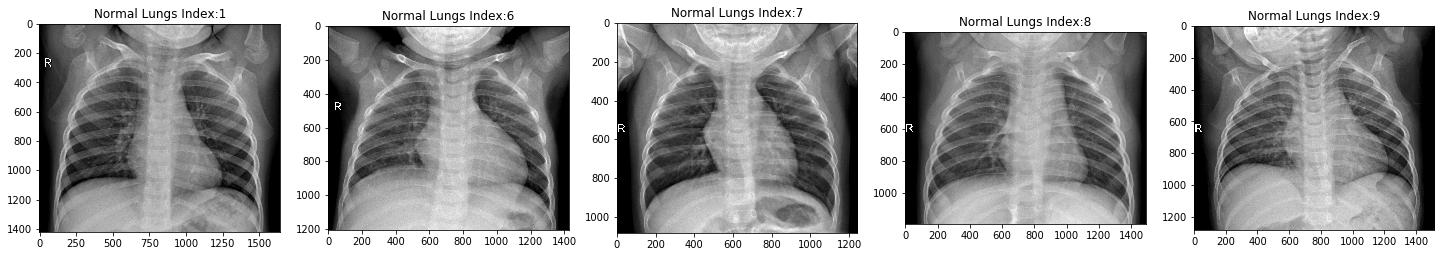

In [7]:
# 「NORMAL」の画像を表示
normimage = train_df[train_df['Label'] == 'NORMAL'].iloc[0:5]
fig, ax = plt.subplots(1, 5, figsize=(25,6))

plot_number = 1
for i in range(len(normimage)): 
    image = cv2.imread(normimage['Image'].iloc[i],1) 
    ax = plt.subplot(1, 5, plot_number)
    title = 'Normal Lungs Index:' + str(normimage.index[i])
    plt.imshow(image)
    plt.title(title)
    plot_number = plot_number+1

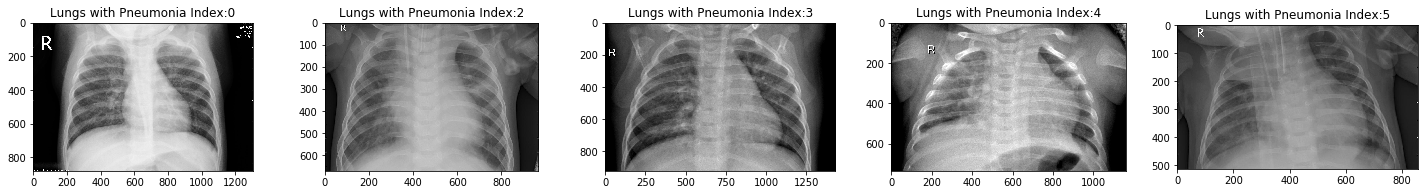

In [8]:
## Pneumonia Lungs 
pneumoniaimage = train_df[train_df['Label'] == 'PNEUMONIA'].iloc[0:5]

fig, ax = plt.subplots(1, 5, figsize=(25,6))

### Plot Pneumonia Lungs 
plot_number = 1
for i in range(len(pneumoniaimage)): 
    image = cv2.imread(pneumoniaimage['Image'].iloc[i],1) 
    ax = plt.subplot(2, 5, plot_number)
    title = 'Lungs with Pneumonia Index:' + str(pneumoniaimage.index[i])
    plt.imshow(image)
    plt.title(title)
    plot_number = plot_number+1

Text(0.5, 1.0, 'Pneumonia')

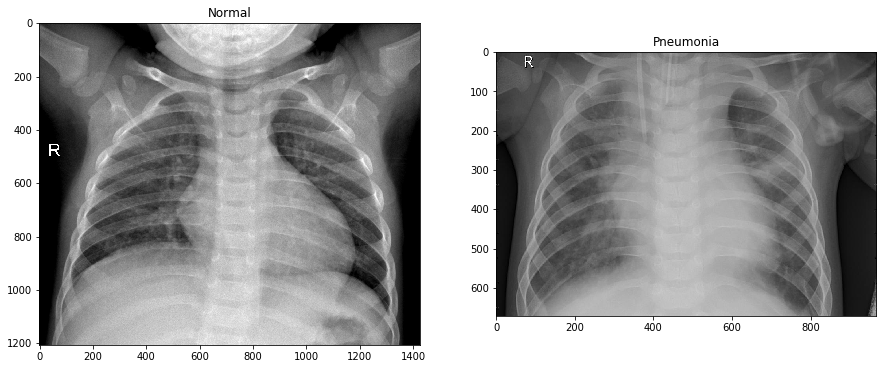

In [9]:
fix, ax = plt.subplots(1, 2, figsize=(15, 15))

# 正常データ
plt.subplot(121)
normimage = cv2.imread(train_df['Image'][train_df['Label'] == 'NORMAL'].iloc[1],1) 
plt.imshow(normimage)
plt.title('Normal')

# 肺炎データ
plt.subplot(122)
pneumoniaimage = cv2.imread(train_df['Image'][train_df['Label'] == 'PNEUMONIA'].iloc[1],1) 
plt.imshow(pneumoniaimage)
plt.title('Pneumonia')

## 画像サイズの確認

In [10]:
# 最初の5レコードをNumpy配列へ変換
temp = []
for i in range(5):
    img = cv2.imread(train_df['Image'][i], 1)
    temp.append(img)

temp_ar = np.array(temp)

In [11]:
# 画像サイズを確認
print(temp[0].shape)
print(temp[1].shape)
print(temp[2].shape)
print(temp[3].shape)
print(temp[4].shape)

(880, 1304, 3)
(1422, 1642, 3)
(672, 968, 3)
(921, 1430, 3)
(735, 1164, 3)


In [13]:
# 画像のサイズ統一
temp_list = []
for i in range(5):
    img = cv2.resize(temp[i], (64, 64))
    temp_list.append(img)

temp_resize = np.array(temp_list)
temp_resize.shape

(5, 64, 64, 3)

Text(0.5, 1.0, 'Resized')

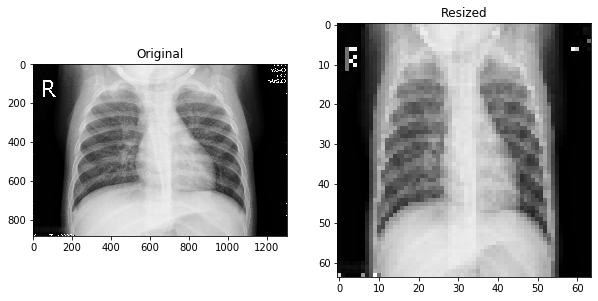

In [15]:
fix, ax = plt.subplots(1, 2, figsize=(10, 10))

# 正常データ
plt.subplot(121)
plt.imshow(temp[0])
plt.title('Original')

# 肺炎データ
plt.subplot(122)
plt.imshow(temp_resize[0])
plt.title('Resized')

## 正規化

In [16]:
# 0番目のレコードの一部を表示
print(temp_resize[0, 0:5, 0:5, 0 ])

# 正規化
temp_resize = temp_resize.astype('float32') / 255

# 0番目のレコードの一部を表示
print(temp_resize[0, 0:5, 0:5, 0 ])

[[2 5 4 3 3]
 [2 4 3 3 2]
 [2 1 4 3 2]
 [3 1 3 5 3]
 [3 3 4 4 2]]
[[0.00784314 0.01960784 0.01568628 0.01176471 0.01176471]
 [0.00784314 0.01568628 0.01176471 0.01176471 0.00784314]
 [0.00784314 0.00392157 0.01568628 0.01176471 0.00784314]
 [0.01176471 0.00392157 0.01176471 0.01960784 0.01176471]
 [0.01176471 0.01176471 0.01568628 0.01568628 0.00784314]]


In [17]:
# 訓練データの読み込みと前処理
img_list = []
lungs = []

# 各画像を読み込んで前処理を加える
for i in range(len(train_df)):
    # 画像の読み込み
    lungs = cv2.imread(train_df['Image'][i],1)
    # 画像のリサイズ（64 x 64）
    lungs = cv2.resize(lungs, (64,64))
    # 画像の正規化
    lungs = lungs.astype('float32') /255
    # リストへ追加
    img_list.append(lungs)
    
# リストからNumpy配列へ変換
X_train = np.array(img_list)

# サイズを確認
X_train.shape

(5216, 64, 64, 3)

In [18]:
# テストデータの読み込みと前処理
img_list = []
lungs = []

# 各画像を読み込んで前処理を加える
for i in range(len(test_df)):
    # 画像の読み込み
    lungs = cv2.imread(test_df['Image'][i],1)
    # 画像のリサイズ（64 x 64）
    lungs = cv2.resize(lungs, (64,64))
    # 画像の正規化
    lungs = lungs.astype('float32') /255
    # リストへ追加
    img_list.append(lungs)
    
# リストからNumpy配列へ変換
X_test = np.array(img_list)

# サイズを確認
X_test.shape

(624, 64, 64, 3)

## ターゲットデータの切り分け

In [19]:
# ターゲットの作成
y_train = np.where(train_df['Label'] == 'PNEUMONIA', 1, 0)
y_test = np.where(test_df['Label'] == 'PNEUMONIA', 1, 0)

# 確認
print(y_train[0:5])
print(y_test[0:5])

[1 0 1 1 1]
[1 1 0 0 1]


In [20]:
# サイズの確認
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5216, 64, 64, 3)
(5216,)
(624, 64, 64, 3)
(624,)


## データの書き出し（中間ファイル）

In [21]:
# 訓練データの書き出し
np.save(train_path + 'X_train.npy', X_train)
np.save(train_path + 'y_train.npy', y_train)

# テストデータの書き出し
np.save(test_path + 'X_test.npy', X_test)
np.save(test_path + 'y_test.npy', y_test)

In [22]:
# メモリをクリア
del X_train
del y_train
del X_test
del y_test

# npyファイルを読み込み
X_train = np.load(train_path + 'X_train.npy')
y_train = np.load(train_path + 'y_train.npy')
X_test = np.load(test_path + 'X_test.npy')
y_test = np.load(test_path + 'y_test.npy')

# サイズの確認
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5216, 64, 64, 3)
(5216,)
(624, 64, 64, 3)
(624,)
